## Determine Circle segments

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import numpy.ma as ma

import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
from datetime import datetime

### User input for circle selection

In [2]:
flightID = "HALO-20240916a"
flight_day = '2024-09-16'

# accepted roll range for a circle
cyclic_max  = 3.5
cyclic_min  = 0.3
acyclic_max = -0.3
acyclic_min = -3.5

bahamasFreq         = 100 # Hz
resamplingTime      =  30 # in seconds [interpolation/averaging interval of raw data]
minimumTimeForCycle =  20 # in minutes

guessRange          =   4 # resampling intervalls before and after the estimated guess

### Open file

In [3]:
flightID = "HALO-2024"+flight_day[5:7]+flight_day[8:10]+"a"

ds = xr.open_zarr("ipns://latest.orcestra-campaign.org/products/HALO/position_attitude/"+flightID+".zarr")
ds


<xarray.Dataset> Size: 207MB
Dimensions:  (time: 3695958)
Coordinates:
    alt      (time) float64 30MB dask.array<chunksize=(262144,), meta=np.ndarray>
    lat      (time) float64 30MB dask.array<chunksize=(262144,), meta=np.ndarray>
    lon      (time) float64 30MB dask.array<chunksize=(262144,), meta=np.ndarray>
  * time     (time) datetime64[ns] 30MB 2024-09-16T10:52:39 ... 2024-09-16T21...
Data variables:
    heading  (time) float64 30MB dask.array<chunksize=(262144,), meta=np.ndarray>
    pitch    (time) float64 30MB dask.array<chunksize=(262144,), meta=np.ndarray>
    roll     (time) float64 30MB dask.array<chunksize=(262144,), meta=np.ndarray>
Attributes:
    source:   BAHAMAS IGI 100 Hz
    version:  1.0.0

### Open dropsonde data

In [5]:
import fsspec
root = "ipns://latest.orcestra-campaign.org/products/HALO/dropsondes/Level_1"
day_folder = root + "/" + flightID

fs = fsspec.filesystem(day_folder.split(":")[0])
filenames = fs.ls(day_folder, detail=False)
datasets = [xr.open_dataset(fsspec.open_local("simplecache::ipns://" + filename), engine="netcdf4")
            for filename in filenames]
launchtimes = np.array([d["launch_time"].values for d in datasets])
ds_sondes = ds.sel(time=launchtimes, method="nearest")

### Full flight track

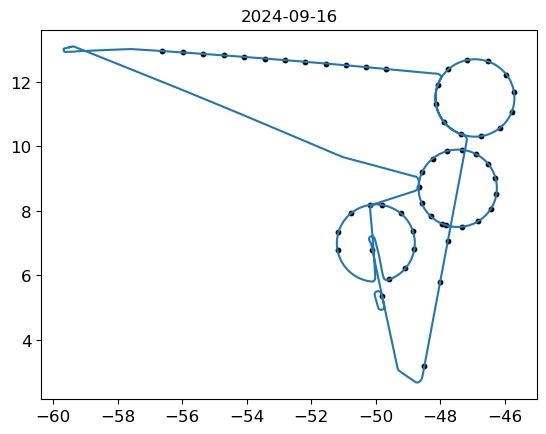

In [6]:
fig = plt.figure()
ax = fig.add_subplot()

plt.xticks(fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

ax.plot(ds.lon,ds.lat)
ax.scatter(ds_sondes.lon, ds_sondes.lat, s=10, c="k")

plt.title(f"{pd.Timestamp(ds.time.values[0]).to_pydatetime():%Y-%m-%d}")
plt.show()

### Flight roll

In [10]:
cycleLength = minimumTimeForCycle * 60 / resamplingTime
trackResampling = bahamasFreq*resamplingTime
resamplingTimeStr= str(resamplingTime)+'s'

resampling

In [11]:
var = ds['roll'].resample(time=resamplingTimeStr).interpolate('linear')

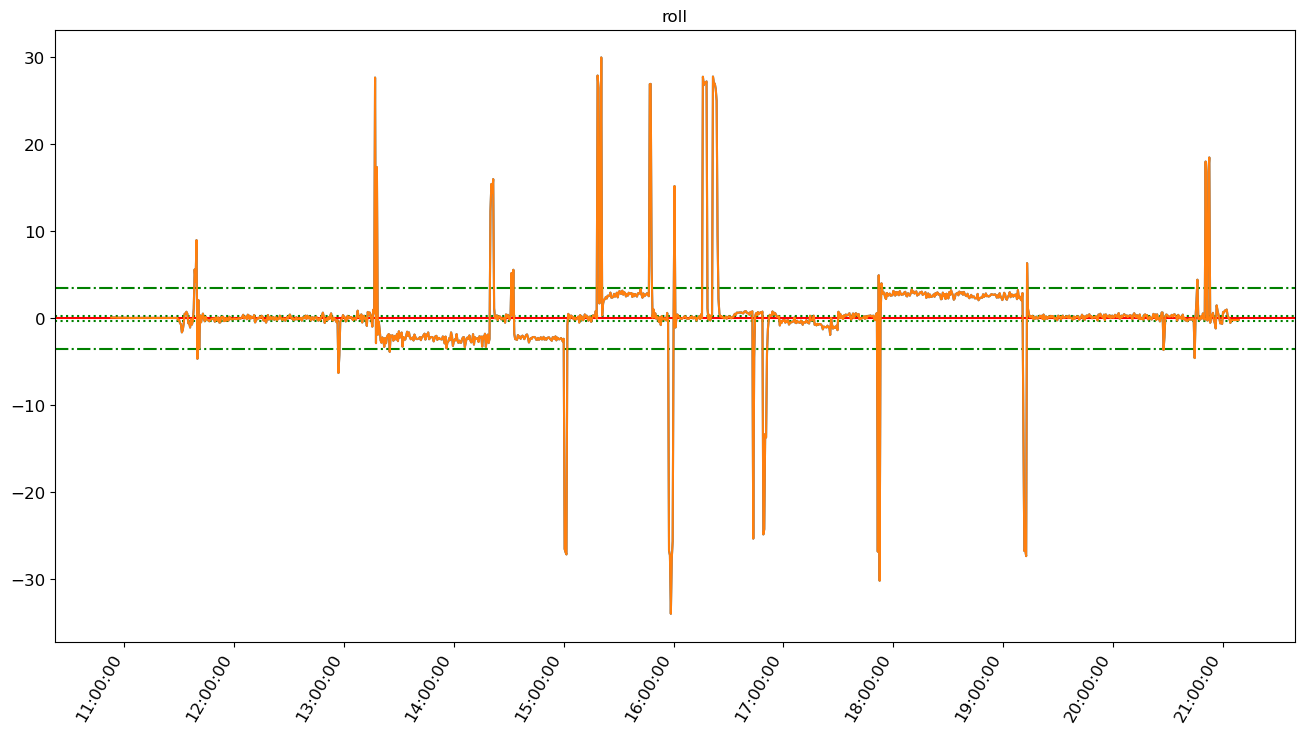

In [12]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

ax.plot(var.time,var)

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)
plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)
plt.title("roll")

plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=cyclic_max, color='g', linestyle='-.')
plt.axhline(y=cyclic_min, color='g', linestyle=':')
plt.axhline(y=acyclic_max, color='g', linestyle=':')
plt.axhline(y=acyclic_min, color='g', linestyle='-.')

ax.plot(var.time,var)
plt.show()

### Select angles within a range

In [13]:
mvar = np.ma.masked_where( ( ( var > 0 ) & (( var >  cyclic_max ) | ( var <  cyclic_min )) ) |
                           ( ( var < 0 ) & (( var > acyclic_max ) | ( var < acyclic_min )) ), var )

### Determine clusters

* find clusters with a certain length
* mask out short clusters

In [14]:
slices = np.ma.flatnotmasked_contiguous(mvar)

# print (slices)

slices_start = np.array([s.start for s in slices])
slices_end   = np.array([s.stop  for s in slices])

j=0
segment=0
for i in slices_start:
    ibeg=i
    iend=min(slices_end[j],var.time.size-1)
    cycle_length = iend-ibeg+1
    j += 1
    circle_start = var.time[ibeg]
    circle_stop = var.time[iend]
    if ( cycle_length <= cycleLength ) :
        for index in range(ibeg, iend):
            mvar.mask[index] = True
    else :
        print (pd.Timestamp(circle_start.time.values).to_pydatetime() , " to ", pd.Timestamp(circle_stop.time.values).to_pydatetime())
        segment += 1 

2024-09-16 13:25:30  to  2024-09-16 14:20:00
2024-09-16 14:33:00  to  2024-09-16 15:00:30
2024-09-16 15:21:00  to  2024-09-16 15:47:00
2024-09-16 17:54:00  to  2024-09-16 19:11:00


### Plot remaining slices

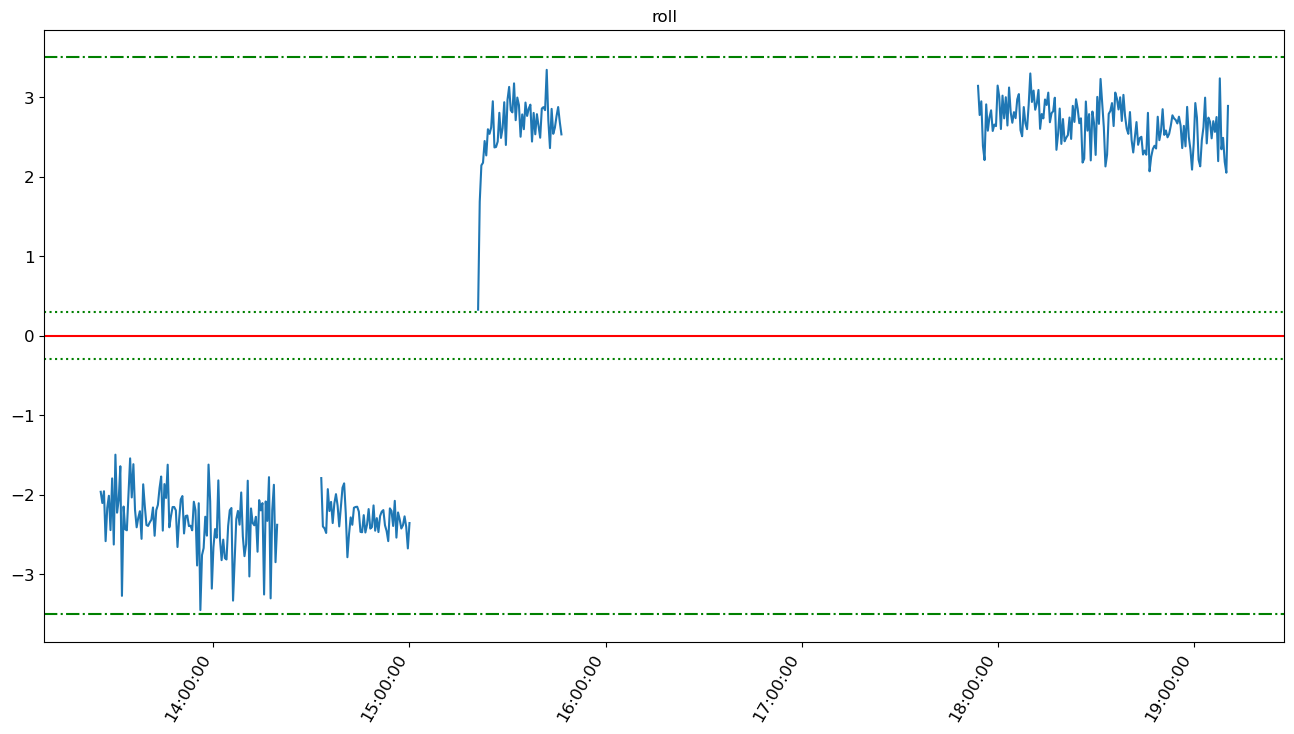

In [15]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)
plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)
plt.title("roll")

plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=cyclic_max, color='g', linestyle='-.')
plt.axhline(y=cyclic_min, color='g', linestyle=':')
plt.axhline(y=acyclic_max, color='g', linestyle=':')
plt.axhline(y=acyclic_min, color='g', linestyle='-.')

ax.plot(var.time,mvar)
plt.show()

### Plot estimated entry time into circle for each circle segement

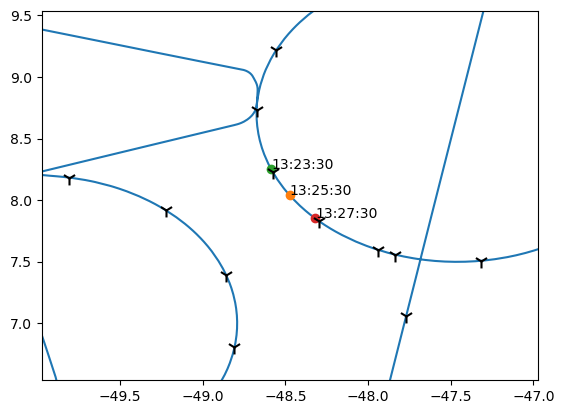

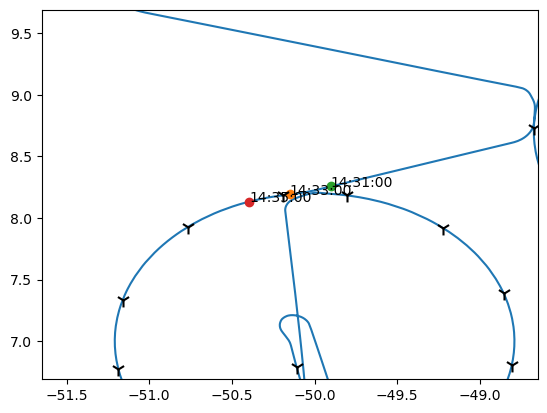

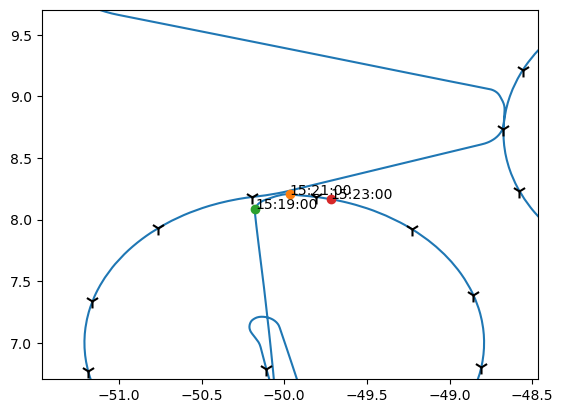

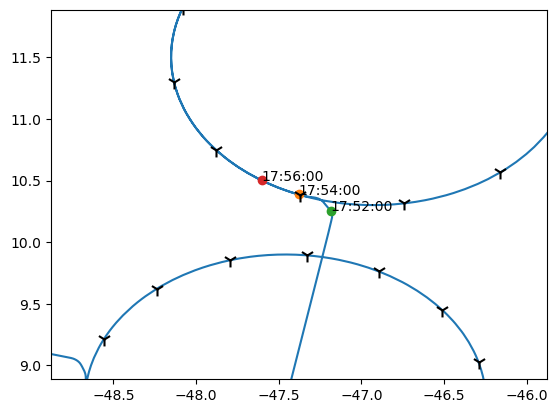

In [16]:
j=0

for i in slices_start:

    ibeg=i
    iend=slices_end[j]

    cycle_length = iend-ibeg+1
    circle_start_bef = var.time[max(ibeg-guessRange,0)]
    circle_start_mid = var.time[ibeg]
    circle_start_aft = var.time[min(ibeg+guessRange,var.time.size-1)]

    if ( cycle_length > cycleLength ) :

        point_bef = ds.isel(time=(max(round(ibeg-guessRange-0.5),0)*trackResampling))
        point_mid = ds.isel(time=(max(round(ibeg           -0.5),0)*trackResampling))
        point_aft = ds.isel(time=(max(round(ibeg+guessRange-0.5),0)*trackResampling))

        fig, ax = plt.subplots()
        ax.plot(ds.lon, ds.lat)

        plt.xlim(point_mid.lon-1.5,point_mid.lon+1.5)
        plt.ylim(point_mid.lat-1.5,point_mid.lat+1.5)

        ax.scatter(point_bef.lon, point_bef.lat, color="tab:green", zorder=3)
        ax.text(point_bef.lon, point_bef.lat, f"{pd.Timestamp(circle_start_bef.time.values).to_pydatetime():%H:%M:%S}")

        ax.scatter(point_mid.lon, point_mid.lat, color="tab:orange", zorder=3)
        ax.text(point_mid.lon, point_mid.lat, f"{pd.Timestamp(circle_start_mid.time.values).to_pydatetime():%H:%M:%S}")

        ax.scatter(point_aft.lon, point_aft.lat, color="tab:red", zorder=3)
        ax.text(point_aft.lon, point_aft.lat, f"{pd.Timestamp(circle_start_aft.time.values).to_pydatetime():%H:%M:%S}")

        # plot sondes
        ax.scatter(ds_sondes.lon, ds_sondes.lat, marker = '1', s = 100, color = 'k', zorder=3)
        segment += 1

    j += 1

    plt.show()

### Plot estimated leaving time of circle for each circle segement

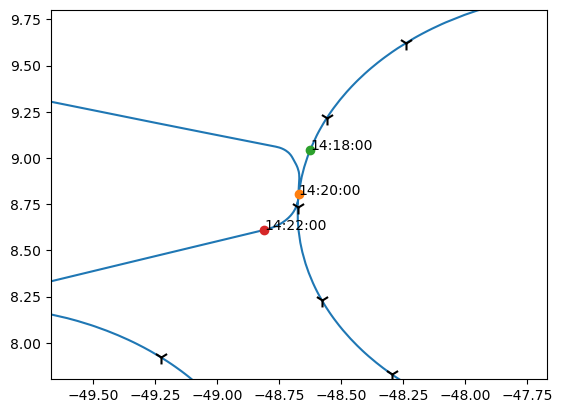

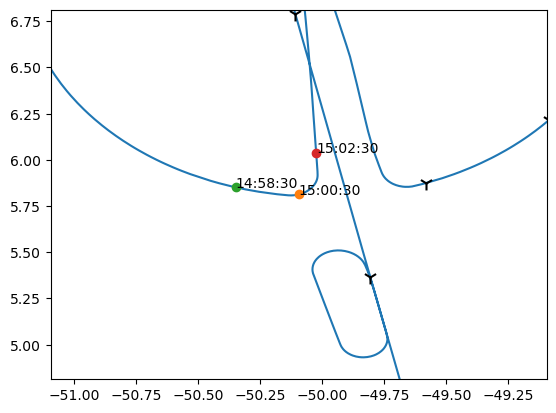

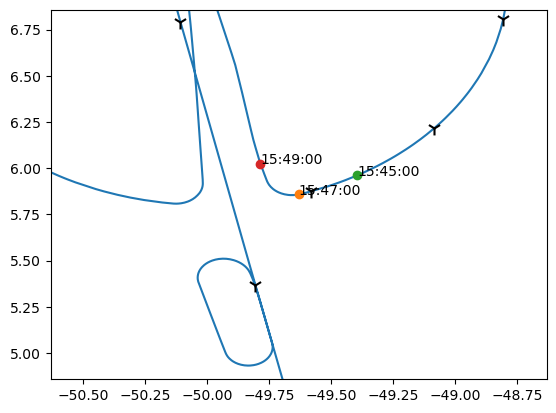

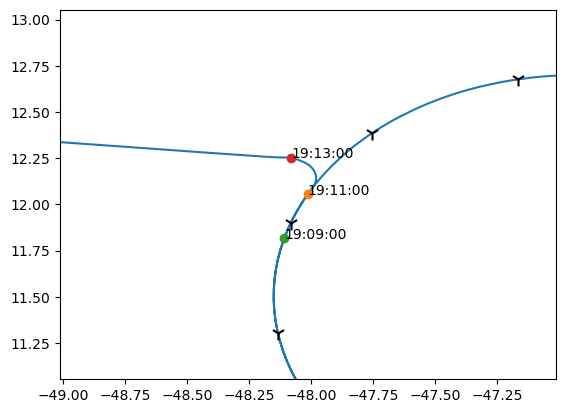

In [17]:
j=0

for i in slices_start:

    ibeg=i
    iend=slices_end[j]

    cycle_length = iend-ibeg+1
    circle_end_bef = var.time[max(iend-guessRange,0)]
    circle_end_mid = var.time[min(iend,var.time.size-1)]
    circle_end_aft = var.time[min(iend+guessRange,var.time.size-1)]

    if ( cycle_length > cycleLength ) :

        point_bef = ds.isel(time=(    round(iend-guessRange-0.5)*trackResampling))
        point_mid = ds.isel(time=(min(round(iend-0.5           )*trackResampling,ds.time.size-1)))
        point_aft = ds.isel(time=(min(round(iend+guessRange-0.5)*trackResampling,ds.time.size-1)))

        fig, ax = plt.subplots()
        ax.plot(ds.lon, ds.lat)

        plt.xlim(point_mid.lon-1,point_mid.lon+1)
        plt.ylim(point_mid.lat-1,point_mid.lat+1)

        ax.scatter(point_bef.lon, point_bef.lat, color="tab:green", zorder=3)
        ax.text   (point_bef.lon, point_bef.lat, f"{pd.Timestamp(circle_end_bef.time.values).to_pydatetime():%H:%M:%S}")

        ax.scatter(point_mid.lon, point_mid.lat, color="tab:orange", zorder=3)
        ax.text   (point_mid.lon, point_mid.lat, f"{pd.Timestamp(circle_end_mid.time.values).to_pydatetime():%H:%M:%S}")

        ax.scatter(point_aft.lon, point_aft.lat, color="tab:red", zorder=3)
        ax.text   (point_aft.lon, point_aft.lat, f"{pd.Timestamp(circle_end_aft.time.values).to_pydatetime():%H:%M:%S}")

        # plot sondes
        ax.scatter(ds_sondes.lon, ds_sondes.lat, marker = '1', s = 100, color = 'k', zorder=3)
        
        segment += 1

    j += 1

    plt.show()